# TensorFlow Scan Examples
#### By [Rob DiPietro](http://rdipietro.github.io) – Version 0.3 – April 22, 2016.

## Contents

- [Overview](#overview)
- [Preliminaries](#preliminaries)
- [Hard Coding the Cumulative Sum](#hard-coding-the-cumulative-sum)
- [Learning the Cumulative Sum](#learning-the-cumulative-sum)
    - [Generating Inputs and Targets](#generating-inputs-and-targets)
    - [Defining the RNN Model from Scratch](#defining-the-rnn-model-from-scratch)
    - [Defining an Optimizer](#defining-an-optimizer)
    - [Training](#training)
    - [Testing Qualitatively](#testing-qualitatively)
    - [Ideas for Playing with the Code](#ideas-for-playing-with-the-code)
- [Some Final Thoughts](#some-final-thoughts)

<a id="overview"></a>
## Overview

`scan` was [recently made available](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/functional_ops.py) in TensorFlow.

`scan` lets us write loops inside a computation graph, allowing backpropagation and all.
We could explicitly unroll the loops ourselves, creating new graph nodes for each loop
iteration, but then the number of iterations is fixed instead of dynamic, and graph
creation can be [extremely slow](https://github.com/tensorflow/tensorflow/issues/511).

Let's go over two examples. First, we'll create a simple cumulative-sum operation using
`scan`. For example, `[1, 2, 2, 2]` as input will produce `[1, 3, 5, 7]` as output. Second,
we'll build a toy RNN from scratch, and we'll have it *learn* the cumulative-sum operation
from example input, target sequences. For example, the RNN will learn to map `[1, 2, 2, 2]`
to `[1, 3, 5, 7]` (approximately).

<a id="hard-coding-the-cumulative-sum"></a>
## Hard Coding the Cumulative Sum

Let's just start with code:

In [1]:
from __future__ import division, print_function
import tensorflow as tf

def fn(previous_output, current_input):
    return previous_output + current_input

elems = tf.Variable([1.0, 2.0, 2.0, 2.0])
elems = tf.identity(elems)
initializer = tf.constant(0.0)
out = tf.scan(fn, elems, initializer=initializer)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(sess.run(out))

[ 1.  3.  5.  7.]


This example shows how `scan` is used: it loops over the first dimension of `elems`, at each step applying `fn`, which takes in the previous step's output and the current step's input. The very first step's previous output is given by `initializer`:
- Iteration 0: `fn(0.0, 1.0) == 1.0`
- Iteration 1: `fn(1.0, 2.0) == 3.0`
- Iteration 2: `fn(3.0, 2.0) == 5.0`
- Iteration 3: `fn(5.0, 2.0) == 7.0`

And why the `elems = tf.identity(elems)` line? `scan` is new, and this is just a temporary workaround for [a bug](https://github.com/tensorflow/tensorflow/issues/1725).

<a id="learning-the-cumulative-sum"></a>
## Learning the Cumulative Sum

Now a more complex example: we'll build a recurrent neural network and *learn* the cumulative-sum function from data.

In [2]:
%reset -f

In [3]:
from __future__ import division, print_function

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import matplotlib.pyplot as plt

import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import functional_ops

<a id="generating-inputs-and-targets"></a>
### Generating Inputs and Targets

First let's write a function for generating input, target sequences, one pair at a time. We'll limit ourselves to inputs with independent time steps, drawn from a standard normal distribution.

Each sequence is 2-D with time on the first axis and inputs or targets on the second. (This way it'd be easy to generalize to the case of multiple inputs/targets per time step.)

In [4]:
def input_target_generator(min_duration=5, max_duration=50):
    """ Generate toy input, target sequences.
    
    Each input sequence has values that are drawn from the standard normal
    distribution, and each target sequence is the corresponding cumulative sum.
    Sequence durations are chosen at random using a discrete uniform
    distribution over `[min_duration, max_duration]`.
    
    Args:
        min_duration: A positive integer. The minimum sequence duration.
        max_duration: A positive integer. The maximum sequence duration.

    Yields:
        A tuple,
        inputs: A 2-D float32 NumPy array with shape `[duration, 1]`.
        targets: A 2-D float32 NumPy array with shape `[duration, 1]`.
    """
    
    while True:
        duration = np.random.randint(min_duration, max_duration)
        inputs = np.random.randn(duration).astype(np.float32)
        targets = np.cumsum(inputs).astype(np.float32)
        yield inputs.reshape(-1, 1), targets.reshape(-1, 1)

<a id="defining-the-rnn-model-from-scratch"></a>
### Defining the RNN Model from Scratch

Next let's define the RNN model. The code is a bit verbose because it's meant to be self explanatory, but the pieces are simple:
- The update for the vanilla RNN is $h_t = \tanh( W_h h_{t-1} + W_x x_t + b )$.
- `_vanilla_rnn_step` is the core of the vanilla RNN: it applies this update by taking in a previous hidden state along with a current input and producing a new hidden state. (The only difference below is that both sides of the equation are transposed, and each variable is replaced with its transpose.)
- `_compute_predictions` applies `_vanilla_rnn_step` to all time steps using `scan`, resulting in hidden states for each time step, and then applies a final linear layer to each state to yield final predictions.
- `_compute_loss` just computes the mean squared Euclidean distance between the ground-truth targets and our predictions.

In [5]:
class Model(object):
    
    def __init__(self, hidden_layer_size, input_size, target_size, init_scale=0.1):
        """ Create a vanilla RNN.
        
        Args:
            hidden_layer_size: An integer. The number of hidden units.
            input_size: An integer. The number of inputs per time step.
            target_size: An integer. The number of targets per time step.
            init_scale: A float. All weight matrices will be initialized using
                a uniform distribution over [-init_scale, init_scale].
        """
        
        self.hidden_layer_size = hidden_layer_size
        self.input_size = input_size
        self.target_size = target_size
        self.init_scale = init_scale
        
        self._inputs = tf.placeholder(tf.float32, shape=[None, input_size],
                                      name='inputs')
        self._targets = tf.placeholder(tf.float32, shape=[None, target_size],
                                       name='targets')
        
        initializer = tf.random_uniform_initializer(-init_scale, init_scale)
        with tf.variable_scope('model', initializer=initializer):
            self._states, self._predictions = self._compute_predictions()
            self._loss = self._compute_loss()
    
    def _vanilla_rnn_step(self, h_prev, x):
        """ Vanilla RNN step.

        Args:
            h_prev: A 1-D float32 Tensor with shape `[hidden_layer_size]`.
            x: A 1-D float32 Tensor with shape `[input_size]`.

        Returns:
            The updated state `h`, with the same shape as `h_prev`.
        """

        h_prev = tf.reshape(h_prev, [1, self.hidden_layer_size])
        x = tf.reshape(x, [1, self.input_size])

        with tf.variable_scope('rnn_block'):
            W_h = tf.get_variable(
                'W_h', shape=[self.hidden_layer_size, self.hidden_layer_size])
            W_x = tf.get_variable(
                'W_x', shape=[self.input_size, self.hidden_layer_size])
            b = tf.get_variable('b', shape=[self.hidden_layer_size],
                                initializer=tf.constant_initializer(0.0))
            h = tf.tanh( tf.matmul(h_prev, W_h) + tf.matmul(x, W_x) + b )
            h = tf.reshape(h, [self.hidden_layer_size], name='h')
            
        return h

    def _compute_predictions(self):
        """ Compute vanilla-RNN states and predictions. """

        with tf.variable_scope('states'):
            initial_state = tf.zeros([self.hidden_layer_size],
                                     name='initial_state')
            states = tf.scan(self._vanilla_rnn_step, self.inputs,
                                         initializer=initial_state, name='states')

        with tf.variable_scope('predictions'):
            W_pred = tf.get_variable(
                'W_pred', shape=[self.hidden_layer_size, self.target_size])
            b_pred = tf.get_variable('b_pred', shape=[self.target_size],
                                     initializer=tf.constant_initializer(0.0))
            predictions = tf.add(tf.matmul(states, W_pred), b_pred, name='predictions')
            
        return states, predictions

    def _compute_loss(self):
        """ Compute l2 loss between targets and predictions. """

        with tf.variable_scope('loss'):
            loss = tf.reduce_mean((self.targets - self.predictions)**2, name='loss')
            return loss
    
    @property
    def inputs(self):
        """ A 2-D float32 placeholder with shape `[dynamic_duration, input_size]`. """
        return self._inputs
    
    @property
    def targets(self):
        """ A 2-D float32 placeholder with shape `[dynamic_duration, target_size]`. """
        return self._targets
    
    @property
    def states(self):
        """ A 2-D float32 Tensor with shape `[dynamic_duration, hidden_layer_size]`. """
        return self._states
    
    @property
    def predictions(self):
        """ A 2-D float32 Tensor with shape `[dynamic_duration, target_size]`. """
        return self._predictions
    
    @property
    def loss(self):
        """ A 0-D float32 Tensor. """
        return self._loss

<a id="defining-an-optimizer"></a>
### Defining an Optimizer

Next let's write an optimizer class. We'll use vanilla gradient descent after gradient "clipping," according to the method described by [Pascanu, Mikolov, and Bengio](http://arxiv.org/abs/1211.5063).

The gradient-clipping method is simple and could instead be called gradient scaling: if the global norm is smaller than `max_global_norm`, do nothing. Otherwise, rescale all gradients so that the global norm becomes `max_global_norm`.

What is the global norm? It's just the norm over *all* gradients, as if they were concatenated together to form one global vector.

In [6]:
class Optimizer(object):
    
    def __init__(self, loss, initial_learning_rate, num_steps_per_decay,
                 decay_rate, max_global_norm=1.0):
        """ Create a simple optimizer.
        
        This optimizer clips gradients and uses vanilla stochastic gradient
        descent with a learning rate that decays exponentially.
        
        Args:
            loss: A 0-D float32 Tensor.
            initial_learning_rate: A float.
            num_steps_per_decay: An integer.
            decay_rate: A float. The factor applied to the learning rate
                every `num_steps_per_decay` steps.
            max_global_norm: A float. If the global gradient norm is less than
                this, do nothing. Otherwise, rescale all gradients so that
                the global norm because `max_global_norm`.
        """
        
        trainables = tf.trainable_variables()
        grads = tf.gradients(loss, trainables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=max_global_norm)
        grad_var_pairs = zip(grads, trainables)
        
        global_step = tf.Variable(0, trainable=False, dtype=tf.int32)
        learning_rate = tf.train.exponential_decay(
            initial_learning_rate, global_step, num_steps_per_decay,
            decay_rate, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        self._optimize_op = optimizer.apply_gradients(grad_var_pairs,
                                                      global_step=global_step)
    
    @property
    def optimize_op(self):
        """ An Operation that takes one optimization step. """
        return self._optimize_op

<a id="training"></a>
### Training

Next let's define and run our training function. This is where we'll run the main optimization loop and export TensorBoard summaries.

In [7]:
def train(sess, model, optimizer, generator, num_optimization_steps,
          logdir='./logdir'):
    """ Train.
    
    Args:
        sess: A Session.
        model: A Model.
        optimizer: An Optimizer.
        generator: A generator that yields `(inputs, targets)` tuples, with
            `inputs` and `targets` both having shape `[dynamic_duration, 1]`.
        num_optimization_steps: An integer.
        logdir: A string. The log directory.
    """
    
    if os.path.exists(logdir):
        shutil.rmtree(logdir)
        
    tf.scalar_summary('loss', model.loss)
    
    ema = tf.train.ExponentialMovingAverage(decay=0.99)
    update_loss_ema = ema.apply([model.loss])
    loss_ema = ema.average(model.loss)
    tf.scalar_summary('loss_ema', loss_ema)
        
    summary_op = tf.merge_all_summaries()
    summary_writer = tf.train.SummaryWriter(logdir=logdir, graph=sess.graph)
    
    sess.run(tf.initialize_all_variables())
    for step in xrange(num_optimization_steps):
        inputs, targets = generator.next()
        loss_ema_, summary, _, _ = sess.run(
            [loss_ema, summary_op, optimizer.optimize_op, update_loss_ema],
            {model.inputs: inputs, model.targets: targets})
        summary_writer.add_summary(summary, global_step=step)
        print('\rStep %d. Loss EMA: %.6f.' % (step+1, loss_ema_), end='')

Now we can train our model:

In [8]:
generator = input_target_generator()
model = Model(hidden_layer_size=256, input_size=1, target_size=1, init_scale=0.1)
optimizer = Optimizer(model.loss, initial_learning_rate=1e-2, num_steps_per_decay=15000,
                      decay_rate=0.1, max_global_norm=1.0)

sess = tf.Session()
train(sess, model, optimizer, generator, num_optimization_steps=45000)

Step 45000. Loss EMA: 0.052013.

After running `tensorboard --logdir ./logdir` and navigating to [http://localhost:6006](http://localhost:6006), we can view our loss summaries. Here the exponential moving average is especially helpful because our raw losses correspond to individual sequences (and are therefore very noisy estimates).

![Loss (Raw)](images/loss_raw.png)

![Loss (EMA)](images/loss_ema.png)

<a id="testing-qualitatively"></a>
### Testing Qualitatively

Finally let's write a function to test the trained RNN qualitatively: we'll plot the original inputs (random real numbers), the ground-truth target (the cumulative sum), and our trained RNN's predictions (hopefully matching the cumulative sum).

In [9]:
def test_qualitatively(sess, model, generator, num_examples=5, figsize=(10, 3)):
    """ Test qualitatively.
    
    Args:
        sess: A Session.
        model: A Model.
        generator: A generator that yields `(inputs, targets)` tuples, with
            `inputs` and `targets` both having shape `[dynamic_duration, 1]`.
        num_examples: An integer. The number of examples to plot.
        figsize: A tuple `(width, height)`, the size of each example's figure.
    """
    
    for i in xrange(num_examples):
        
        inputs, targets = generator.next()
        predictions = sess.run(model.predictions, {model.inputs: inputs})
        
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=figsize)
        ax[0].plot(inputs.flatten(), label='inputs')
        ax[0].legend()
        ax[1].plot(targets.flatten(), label='targets')
        ax[1].plot(predictions.flatten(), 'o', label='predictions')
        ax[1].legend()

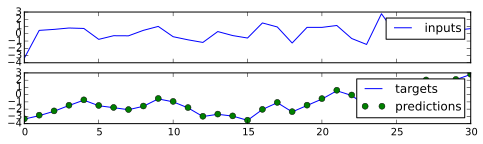

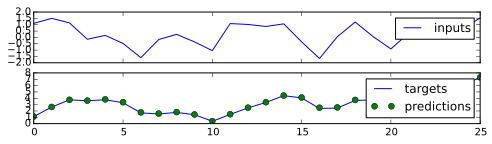

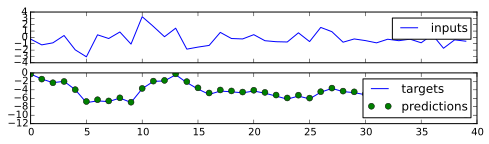

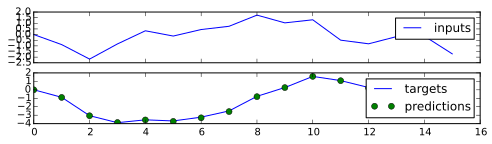

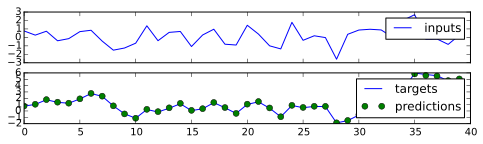

In [10]:
test_qualitatively(sess, model, generator, figsize=(8, 2))

<a id="ideas-for-playing-with-the-code"></a>
### Ideas for Playing with the Code

If you'd like to, you can download this notebook and experiment with the code yourself. Here are a few questions to help spark a some ideas:

- **How many hidden units are needed?** The cumulative sum can be computed using a *linear* transformation at each time step with just one hidden unit: we just initialize it to $0.0$ and then add $x_t$ at each time step. This is *not* the solution that the RNN learned (we used 256 hidden units, and each is squashed between -1.0 and 1.0 at each time step). Try reducing the hidden layer size by factors of 2, and see if/when performance takes a hit.
- **How sensitive is training to the initial learning rate?** Try varying the initial learning rate above by one order of magnitude at a time. Would you say that performance depends heavily on this parameter?
- **How sensitive is training to the initial learning rate without gradient clipping?** In the implementation above, we clipped our gradients (or in reality we scaled them globally). Try training without scaled gradients and see if you can find an initial learning rate that works. Is convergence more sensitive or less sensitive to the initial learning rate?
- **Does the RNN generalize to other inputs?** Above, we trained and tested the RNN using inputs with time steps that were drawn from a standard normal distribution. See what happens if you test this trained model using other inputs, for example a sine wave or a function that doesn't have an average value of 0.0.

<a id="some-final-thoughts"></a>
## Some Final Thoughts

Aside the simple `scan` example, we built and trained a vanilla RNN from scratch. It is written with simplicity in mind and is largely a toy example. Here are some reasons why:

- **We're using a batch size of 1.** This is inefficient: it's analogous to performing 20 different vector-vector multiplies to multiply one vector by twenty others, instead of performing one matrix-vector multiply.
- **We're using one hidden layer.** We could easily extend the above code to handle multiple layers: we'd run `scan` to get the first layer, then run it again to get the second layer, and so on. (The states of the previous layer become the inputs to the next layer.)
- **The vanilla RNN isn't often used because it has trouble learning.** In practice we'd replace the vanilla-RNN block with a long short-term memory (LSTM) block or a gated recurrent unit (GRU) block, both of which were designed to avoid the vanishing gradient problem, or perhaps one could use the recent [identity-initialization-plus-ReLU modification of the vanilla RNN](http://arxiv.org/abs/1504.00941).
- **Fourth, we're using full backpropagation through time, performing a complete forward, backward pass for *each* gradient update.** This means that the number of updates per time is low, leading to longer training times. An alternative is to use truncated backpropagation through time, updating after shorter forward-backward passes in time, but still capturing long-term dependencies by carrying the hidden states over from pass to pass.

This post is also available as a [Jupyter notebook](https://github.com/rdipietro/jupyter-notebooks). If you see any mistakes or have any questions, please open a GitHub issue.